In [1]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, top_k_accuracy_score
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)



Using device: mps


In [2]:
data_path = '/Users/sanansharifzade/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1'
data_path

'/Users/sanansharifzade/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1'

In [3]:
os.listdir(data_path)

['compressed_dataset']

In [4]:
compressed_dataset_path = os.path.join(data_path, 'compressed_dataset')

countries = os.listdir(compressed_dataset_path)
countries

['Bhutan',
 'Kenya',
 'Botswana',
 'Poland',
 'Tunisia',
 'Eswatini',
 'Belarus',
 'Sweden',
 'Russia',
 'Norway',
 'Tanzania',
 'Luxembourg',
 'Sri Lanka',
 'Brazil',
 'Faroe Islands',
 'Kyrgyzstan',
 'Ghana',
 'US Virgin Islands',
 'San Marino',
 'Ukraine',
 'Svalbard and Jan Mayen',
 'France',
 'Jersey',
 'American Samoa',
 'Ecuador',
 'Nepal',
 'South Sudan',
 'Bermuda',
 'Guatemala',
 'Belgium',
 'Gibraltar',
 'Turkey',
 'Netherlands',
 'Guam',
 'Hong Kong',
 'Malaysia',
 'Indonesia',
 'Estonia',
 'Iraq',
 'Spain',
 'Montenegro',
 'Costa Rica',
 'Macao',
 'Serbia',
 'South Korea',
 'Croatia',
 'Australia',
 'Northern Mariana Islands',
 'Myanmar',
 'Lesotho',
 'Latvia',
 'United Kingdom',
 'Qatar',
 'Germany',
 'Laos',
 'Nigeria',
 'Albania',
 'Mongolia',
 'Uruguay',
 'Venezuela',
 'Slovakia',
 'Argentina',
 'Taiwan',
 'United States',
 'Portugal',
 'Ireland',
 'Antarctica',
 'Dominican Republic',
 'Isle of Man',
 'Switzerland',
 'Mozambique',
 'Lithuania',
 'Japan',
 'Senegal',
 '

In [19]:
image_paths = []
image_labels = []

for country in countries:
    country_path = os.path.join(compressed_dataset_path, country)
    if os.path.isdir(country_path):
        if len(os.listdir(country_path)) < 50:
            continue
        for image_filename in os.listdir(country_path):
            full_image_path = os.path.join(country_path, image_filename)
            image_paths.append(full_image_path)
            image_labels.append(country)





In [6]:

le = LabelEncoder()
y = le.fit_transform(image_labels)

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, y, test_size=0.2, random_state=0, stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 39537 Test: 9885


In [7]:
def take_subset(paths, y, n, seed=0):
    paths = np.array(paths)
    y = np.array(y)
    if n >= len(paths):
        return paths.tolist(), y.tolist()
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=seed)
    idx, _ = next(sss.split(paths, y))
    return paths[idx].tolist(), y[idx].tolist()

X_train_baby, y_train_baby = take_subset(X_train, y_train, 2000)
X_test_baby,  y_test_baby  = take_subset(X_test,  y_test,  500)

In [14]:
import torch
from transformers import CLIPModel, CLIPProcessor

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_name = "openai/clip-vit-base-patch32"

clip = CLIPModel.from_pretrained(model_name, use_safetensors=True).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

@torch.no_grad()
def embed(paths, batch_size=64):
    all_feats = []
    for i in range(0, len(paths), batch_size):
        batch = paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch]
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip.get_image_features(**inputs)
        feats = feats / feats.norm(dim=-1, keepdim=True)  # normalize helps
        all_feats.append(feats.cpu().numpy())
    return np.vstack(all_feats)


Xtr_small, ytr_small = take_subset(X_train, y_train, n=2000, seed=0)
Xte_small, yte_small = take_subset(X_test,  y_test,  n=500,  seed=1)


In [57]:
Etr_small = embed(Xtr_small, batch_size=64)
Ete_small = embed(Xte_small, batch_size=64)

clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight = "balanced")
clf.fit(Etr_small, ytr_small)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [58]:
pred = clf.predict(Ete_small)
print("Baby accuracy:", accuracy_score(yte_small, pred))

Baby accuracy: 0.356


In [20]:
Etr = embed(X_train, batch_size=64)
Ete = embed(X_test,  batch_size=64)

clf_full = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_full.fit(Etr, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1)

In [21]:
pred_full = clf_full.predict(Ete)
print("Full accuracy:", accuracy_score(y_test, pred_full))

Full accuracy: 0.6152756702073849


In [27]:
probs = clf.predict_proba(Ete)  # shape: [num_test, num_classes]

def show_topk(i, k=5):
    p = probs[i]
    topk_idx = np.argsort(p)[-k:][::-1]
    topk_labels = le.inverse_transform(topk_idx)

    print("Image:", X_test[i])
    print("True:", le.inverse_transform([y_test[i]])[0])
    print("Top predictions:")
    for rank, (lab, cls_i) in enumerate(zip(topk_labels, topk_idx), start=1):
        print(f"  {rank}. {lab:20s}  prob={p[cls_i]:.4f}")

show_topk(90, k=5)

Image: /Users/sanansharifzade/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1/compressed_dataset/Singapore/canvas_1629834345.jpg
True: Singapore
Top predictions:
  1. Japan                 prob=0.1804
  2. Singapore             prob=0.1446
  3. United States         prob=0.0665
  4. Thailand              prob=0.0654
  5. Brazil                prob=0.0413


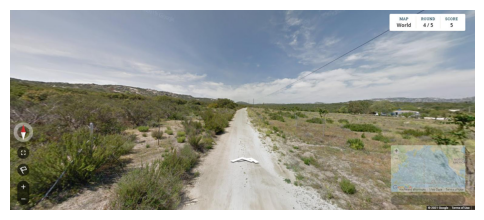

Image: /Users/sanansharifzade/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1/compressed_dataset/United States/canvas_1629348306.jpg
True: United States
Top predictions:
  1. United States         prob=0.1729
  2. Brazil                prob=0.1020
  3. South Africa          prob=0.1018
  4. Mexico                prob=0.0492
  5. Spain                 prob=0.0482


In [50]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image_topk(i, k=5):
    img = Image.open(X_test[i]).convert("RGB")
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    show_topk(i, k=k)

show_image_topk(8040, k=5)

In [51]:


# if you already have probs from clf.predict_proba(Ete)
pred = np.argmax(probs, axis=1)

print("F1 macro:   ", f1_score(y_test, pred, average="macro"))
print("F1 weighted:", f1_score(y_test, pred, average="weighted"))
print("F1 micro:   ", f1_score(y_test, pred, average="micro"))  # often ~= accuracy in multiclass

F1 macro:    0.08016817891497567
F1 weighted: 0.3822382826665684
F1 micro:    0.4878098128477491


In [ ]:
# import joblib
# clf = joblib.load("geo_clip_logreg.joblib")
# le  = joblib.load("label_encoder.joblib")

In [63]:

svm = LinearSVC(C=3)
clf = CalibratedClassifierCV(svm)
clf.fit(Etr, y_train)
pred = clf.predict(Ete)
print("C=", C,
        "acc=", round(accuracy_score(y_test, pred), 3),
        "macroF1=", round(f1_score(y_test, pred, average="macro"), 3),
        "wF1=", round(f1_score(y_test, pred, average="weighted"), 3))

/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
 

C= 10.0 acc= 0.66 macroF1= 0.404 wF1= 0.634


In [65]:



pred = clf.predict(Ete)  # simplest way to get predicted labels

print("accuracy:", accuracy_score(y_test, pred))
print("f1 macro:", f1_score(y_test, pred, average="macro"))
print("f1 weighted:", f1_score(y_test, pred, average="weighted"))

# optional: per-country breakdown
print(classification_report(y_test, pred, target_names=le.classes_, digits=3))

accuracy: 0.6602933737986849
f1 macro: 0.4041548271819493
f1 weighted: 0.6339087065395529
                      precision    recall  f1-score   support

           Argentina      0.449     0.384     0.414       138
           Australia      0.725     0.742     0.733       341
             Austria      0.556     0.507     0.530        69
          Bangladesh      0.600     0.429     0.500        21
             Belgium      0.667     0.045     0.085        44
             Bolivia      0.444     0.174     0.250        23
            Botswana      0.704     0.655     0.679        29
              Brazil      0.574     0.692     0.628       464
            Bulgaria      0.714     0.465     0.563        43
            Cambodia      0.000     0.000     0.000        24
              Canada      0.534     0.312     0.394       276
               Chile      0.161     0.077     0.104        65
            Colombia      0.333     0.100     0.154        50
             Croatia      0.600     0.115

/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sanansharifzade/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [66]:
probs = clf.predict_proba(Ete)
top5 = np.argsort(probs, axis=1)[:, -5:][:, ::-1]  # indices of top 5 classes

i = 0  # pick a test image index
print("True:", le.inverse_transform([y_test[i]])[0])
print("Top-5:", le.inverse_transform(top5[i]))
print("Probs:", probs[i, top5[i]])

True: United States
Top-5: ['United States' 'France' 'Sweden' 'Spain' 'Japan']
Probs: [0.7772546  0.04807069 0.02639054 0.02504091 0.01833852]


In [64]:
import joblib
joblib.dump(clf, "geo_svm_calibrated.joblib")
joblib.dump(le,  "label_encoder.joblib")

['label_encoder.joblib']